In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import feature_util_UPFall
import seaborn as sns
from sklearn.model_selection import train_test_split

## I - Unfiltered

In [2]:
df = pd.read_csv("New Datasets/UPFallWristData.csv")
df


,acc_x_axis,acc_y_axis,acc_z_axis,ang_vel_x_axis,ang_vel_y_axis,ang_vel_z_axis,Activity,Trial,Tag
0,-1.240,-0.557,0.227,-75.854,44.024,315.915,1,1,7
1,-1.240,-0.557,0.227,-28.780,55.549,344.146,1,1,7
2,-1.884,-0.687,0.251,27.256,87.134,372.012,1,1,7
3,-1.884,-0.687,0.251,2.866,117.683,356.463,1,1,7
4,-1.597,-0.646,0.112,10.000,30.671,126.768,1,1,7
...,...,...,...,...,...,...,...,...,...
294673,0.310,0.545,0.835,1.220,3.537,-1.220,11,3,11
294674,0.304,0.549,0.833,0.976,2.317,-1.159,11,3,11
294675,0.318,0.555,0.824,3.598,2.866,-1.402,11,3,11
294676,0.321,0.561,0.822,-0.183,2.073,0.000,11,3,11


<AxesSubplot: >

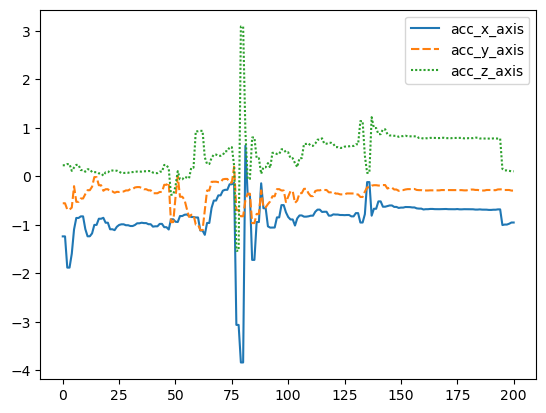

In [3]:
# sns.lineplot(data=df[(df['Activity'] == 1)].loc[300:400, ['acc_x_axis', 'acc_y_axis', 'acc_z_axis', 'Activity', 'Trial']])
sns.lineplot(data=df[(df['Activity'] == 1)].loc[0:200, ['acc_x_axis', 'acc_y_axis', 'acc_z_axis']])

<AxesSubplot: >

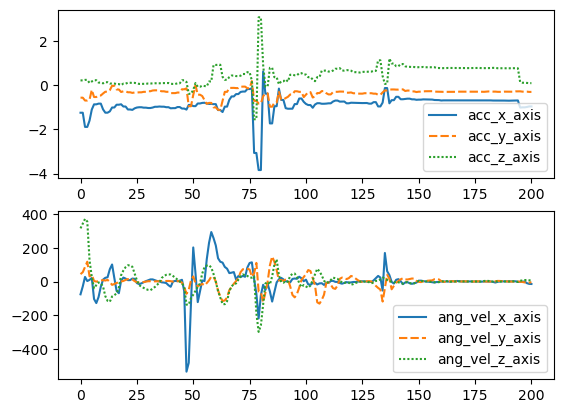

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)

sns.lineplot(data=df[(df['Activity'] == 1)].loc[0:200, ['acc_x_axis', 'acc_y_axis', 'acc_z_axis']], ax=axs[0])
sns.lineplot(data=df[(df['Activity'] == 1)].loc[0:200, ['ang_vel_x_axis', 'ang_vel_y_axis', 'ang_vel_z_axis']], ax=axs[1])

In [5]:
df_falls_renamed = df.copy()
df_falls_renamed.loc[(df_falls_renamed['Activity'] == 2) |
                     (df_falls_renamed['Activity'] == 3) |
                     (df_falls_renamed['Activity'] == 4) |
                     (df_falls_renamed['Activity'] == 5),
                     'Activity'] = 1

df_falls_renamed['Activity'].value_counts()

6     54568
7     54032
8     53689
11    50872
1     45951
10    26694
9      8872
Name: Activity, dtype: int64

In [6]:
df_binary = df_falls_renamed.copy()
df_binary.loc[(df_binary['Activity'] == 6) |
                     (df_binary['Activity'] == 7) |
                     (df_binary['Activity'] == 8) |
                     (df_binary['Activity'] == 9) |
                     (df_binary['Activity'] == 10) |
                     (df_binary['Activity'] == 11),
                     'Activity'] = 0
df_binary['Activity'].value_counts()

0    248727
1     45951
Name: Activity, dtype: int64

In [7]:
Fs = 18.4 # Hz
frame_size = int(Fs * 5) # 100 Hz and 5s window
hop_size = int(frame_size * 0.5) # 50% overlap
# hop_size = int(frame_size * 1) # 50% overlap

In [8]:
# df_ticwatch = pd.read_csv("New Datasets/ticwatch_dataset_gyro.csv", index_col=0)
# df_ticwatch = df_ticwatch.drop(columns=['timestamp'], axis=1)
# df_ticwatch['outcome'] = 0
# df_ticwatch

In [9]:
df_binary = df_binary.drop(columns=['Trial', 'Tag'])
df_binary = df_binary.rename(mapper={'acc_x_axis':'acc_x',
                                     'acc_y_axis':'acc_y',
                                     'acc_z_axis':'acc_z',
                                     'ang_vel_x_axis':'gyro_x',
                                     'ang_vel_y_axis':'gyro_y',
                                     'ang_vel_z_axis':'gyro_z',
                                     'Activity':'outcome'}, axis=1)

In [10]:
# df_binary_combined_unfiltered = pd.concat([df_binary, df_ticwatch]).reset_index(drop=True)
df_binary_combined_unfiltered = df_binary
df_binary_combined_unfiltered
# df_binary_combined_filtered = feature_util_UPFall.apply_filter(df_binary_combined.drop(columns=['outcome']), Fs)
# df_binary_combined_filtered['outcome'] = df_binary_combined['outcome']

binary_frames, y_binary = feature_util_UPFall.get_frames_with_gyro(df_binary_combined_unfiltered, frame_size, hop_size, True)
binary_features = feature_util_UPFall.extract_features_with_gyro(binary_frames)
binary_features_df = pd.DataFrame(binary_features)
y_binary_df = pd.DataFrame(y_binary, columns=['outcome'])
binary_features_and_outcome = pd.concat([binary_features_df, y_binary_df], axis=1)

c:\Users\Alex\OneDrive - The University of Nottingham\Comp Sci\Year 3\Dissertation\Code\feature_util_UPFall.py:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['outcome'][i: i + frame_size])[0][0]


In [11]:
binary_falls = binary_features_and_outcome[binary_features_and_outcome['outcome'] == 1]
binary_non_falls = binary_features_and_outcome[binary_features_and_outcome['outcome'] == 0]

undersampled_non_falls = binary_non_falls.sample(n=len(binary_falls), random_state=42)
binary_balanced = pd.concat([binary_falls, undersampled_non_falls])
binary_balanced = binary_balanced.sample(frac=1, random_state=42)
binary_balanced_x = binary_balanced.drop(columns=['outcome'], axis=1)
binary_balanced_y = binary_balanced.loc[:, ['outcome']]
binary_balanced_y.value_counts()

outcome
0          999
1          999
dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(binary_balanced_x, binary_balanced_y, test_size=0.25, random_state=0, stratify=binary_balanced_y)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1498, 22), (500, 22), (1498, 1), (500, 1))

In [14]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 749, 1: 749}

### Traditional Machine Learning Methods

In [15]:
model_name_array = []
model_acc_array = []

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [18]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [19]:
# Predict on the test set
predicted = knn_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted))
print(accuracy_score(y_test, predicted))
print(f1_score(y_test, predicted, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
model_name_array.append("knn")
model_acc_array.append(accuracy_score(y_test, predicted))

[[212  38]
 [ 63 187]]
0.798
0.798


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [20]:
# from sklearn.model_selection import GridSearchCV

# max_features_range = np.arange(1, 6, 1)
# n_estimators_range = np.arange(10, 210, 10)
# n_neighbors_range = np.arange(1, 100, 1)
# # param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, n_neighbors = n_neighbors_range)
# param_grid = dict(n_neighbors = n_neighbors_range)

# knnTest = KNeighborsClassifier(n_neighbors=5)

# grid = GridSearchCV(estimator=knnTest, param_grid=param_grid, scoring='accuracy', cv=5)

# grid.fit(X_train, y_train)
# print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

In [21]:
from sklearn import svm

In [22]:
svm_model = svm.SVC(kernel='linear', C=1, random_state=0)
# gaussian
svm_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', random_state=0)

In [23]:
# Predict on the test set
predicted_svm = svm_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_svm))
print(accuracy_score(y_test, predicted_svm))
print(f1_score(y_test, predicted_svm, average='micro'))

model_name_array.append("svm")
model_acc_array.append(accuracy_score(y_test, predicted_svm))

[[164  86]
 [ 82 168]]
0.664
0.664


In [24]:
svm_rbf_model = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_rbf_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=0)

In [25]:
# Predict on the test set
predicted_svm_rbf = svm_rbf_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_svm_rbf))
print(accuracy_score(y_test, predicted_svm_rbf))
print(f1_score(y_test, predicted_svm_rbf, average='micro'))
model_name_array.append("svm_rbf")
model_acc_array.append(accuracy_score(y_test, predicted_svm_rbf))


[[223  27]
 [104 146]]
0.738
0.738


In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_35204\2856838272.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
# Predict on the test set
predicted_rf = rf_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_rf))
print(accuracy_score(y_test, predicted_rf))
print(f1_score(y_test, predicted_rf, average='micro'))
model_name_array.append("rf")
model_acc_array.append(accuracy_score(y_test, predicted_rf))

[[213  37]
 [ 33 217]]
0.86
0.8599999999999999


In [29]:
from sklearn.naive_bayes import GaussianNB

In [30]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [31]:
# Predict on the test set
predicted_nb = nb_model.predict(X_test)

# Print metrics
print(confusion_matrix(y_test, predicted_nb))
print(accuracy_score(y_test, predicted_nb))
print(f1_score(y_test, predicted_nb, average='micro'))
model_name_array.append("nb")
model_acc_array.append(accuracy_score(y_test, predicted_nb))


[[228  22]
 [137 113]]
0.682
0.682


In [32]:
best_trad_model_acc = max(model_acc_array)
index = model_acc_array.index(max(model_acc_array))
best_trad_model = model_name_array[index]
print(f"Best model: {best_trad_model}, Accuracy: {best_trad_model_acc}")
# model_acc_array

Best model: rf, Accuracy: 0.86


In [33]:
for i in range(0, len(model_name_array)):
    print(f"name: {model_name_array[i]}, accuracy: {model_acc_array[i]}")

name: knn, accuracy: 0.798
name: svm, accuracy: 0.664
name: svm_rbf, accuracy: 0.738
name: rf, accuracy: 0.86
name: nb, accuracy: 0.682


In [34]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 749, 1: 749}

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [36]:
unfiltered_model_dictionary = {"knn": knn_model,
                             "svm": svm_model,
                             "svm_rbf": svm_rbf_model,
                             "rf": rf_model,
                             "nb": nb_model}

In [37]:
def perform_cross_val_all_models(model_dictionary, X_train, y_train, num_folds=5):
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    scores_array = []

    for model_name in model_dictionary:
        model = model_dictionary[model_name]
        scores = cross_val_score(model, X_train, y_train, cv=cv)
        scores_array.append((model_name, scores))
    
    return scores_array

In [38]:
scores_array = perform_cross_val_all_models(unfiltered_model_dictionary, X_train, y_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [39]:
for cv_tuple in scores_array:
    print("%s Accuracy: %0.2f (+/- %0.2f)" % (cv_tuple[0], cv_tuple[1].mean(), cv_tuple[1].std() * 2))

knn Accuracy: 0.79 (+/- 0.03)
svm Accuracy: 0.68 (+/- 0.04)
svm_rbf Accuracy: 0.75 (+/- 0.02)
rf Accuracy: 0.83 (+/- 0.02)
nb Accuracy: 0.68 (+/- 0.01)


In [40]:
from sklearn.metrics import classification_report

In [41]:
def print_all_classification_reports(model_dictionary, X_test, y_test): # broken!!! only works for filtered data. TODO: change X_test and y_test to params
        for model_name in model_dictionary:
                print("Classification report for %s" % model_name)
                model = model_dictionary[model_name]
                predicted = model.predict(X_test)
                print(classification_report(y_test, predicted))
                print("=====================================================")

In [42]:
print_all_classification_reports(unfiltered_model_dictionary, X_test, y_test)

Classification report for knn
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       250
           1       0.83      0.75      0.79       250

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500

Classification report for svm
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       250
           1       0.66      0.67      0.67       250

    accuracy                           0.66       500
   macro avg       0.66      0.66      0.66       500
weighted avg       0.66      0.66      0.66       500

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       250
           1       0.84      0.58      0.69       250

    accuracy                           0.74       500
   macro avg       0.76      0.74 

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [43]:
def print_all_classification_reports_training(model_dictionary, X_train, y_train):
        for model_name in model_dictionary:
                print("Classification report for %s" % model_name)
                model = model_dictionary[model_name]
                predicted = model.predict(X_train)
                print(classification_report(y_train, predicted))
                print("=====================================================")

In [44]:
print_all_classification_reports_training(unfiltered_model_dictionary, X_train, y_train)

Classification report for knn
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       749
           1       0.90      0.82      0.86       749

    accuracy                           0.87      1498
   macro avg       0.87      0.87      0.87      1498
weighted avg       0.87      0.87      0.87      1498

Classification report for svm
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       749
           1       0.68      0.67      0.68       749

    accuracy                           0.68      1498
   macro avg       0.68      0.68      0.68      1498
weighted avg       0.68      0.68      0.68      1498

Classification report for svm_rbf


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.70      0.90      0.79       749
           1       0.86      0.62      0.72       749

    accuracy                           0.76      1498
   macro avg       0.78      0.76      0.75      1498
weighted avg       0.78      0.76      0.75      1498

Classification report for rf
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       749

    accuracy                           1.00      1498
   macro avg       1.00      1.00      1.00      1498
weighted avg       1.00      1.00      1.00      1498

Classification report for nb
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       749
           1       0.81      0.47      0.60       749

    accuracy                           0.68      1498
   macro avg       0.72      0.68      0.67      1498
weighted avg    

In [154]:
from joblib import dump, load
# save clf using joblib
# dump(rf_model, 'New Models/rf_filtered_normalised.joblib')
# dump(rf_model, 'Final Models/exp3_rf_unfiltered.joblib')

['Final Models/exp3_rf_unfiltered.joblib']

### Deep Learning

#### The models below are trained using data which went through low-pass filter

In [46]:
binary_frames.shape, y_binary.shape

((6405, 92, 6), (6405,))

In [47]:
X_undersampled, y_undersampled = feature_util_UPFall.balance_windows_undersample(binary_frames, y_binary)
X_undersampled.shape, y_undersampled.shape

((1998, 92, 6), (1998,))

In [48]:
# X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(binary_frames, y_binary, test_size=0.25, random_state=0, stratify=y_binary)
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_undersampled, y_undersampled, test_size=0.25, random_state=0, stratify=y_undersampled)
X_raw_train.shape, X_raw_test.shape, y_raw_train.shape

((1498, 92, 6), (500, 92, 6), (1498,))

In [49]:
X_raw_train[0].shape

(92, 6)

In [50]:
# X_TRAIN_SIZE = 12277
# X_TEST_SIZE = 4093
X_TRAIN_SIZE = X_raw_train.shape[0]
X_TEST_SIZE = X_raw_test.shape[0]
X_TRAIN_WINDOW_SIZE = X_raw_train.shape[1]
X_TEST_WINDOW_SIZE = X_raw_test.shape[1]

In [51]:
from sklearn.tree import DecisionTreeClassifier

# X = data_unfiltered[["x_ax", "y_ax", "z_ax"]]
# y = data_unfiltered["outcome"]
# # y = data["AnyFall"]

In [52]:
X_raw_train = X_raw_train.reshape(X_TRAIN_SIZE, X_TRAIN_WINDOW_SIZE, 6, 1)
X_raw_test = X_raw_test.reshape(X_TEST_SIZE, X_TEST_WINDOW_SIZE, 6, 1)

In [53]:
X_raw_train[0].shape, X_raw_test[0].shape

((92, 6, 1), (92, 6, 1))

In [54]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [55]:
cnn_model = Sequential()
cnn_model.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_train[0].shape))
cnn_model.add(Conv2D(32, (2, 2), activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(2, activation='softmax'))

In [56]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
NUMBER_OF_EPOCHS = 15

In [58]:
history = cnn_model.fit(X_raw_train, y_raw_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_raw_test, y_raw_test), verbose=1)

Epoch 1/15
47/47 [==============================] - 2s 23ms/step - loss: 0.5792 - accuracy: 0.6996 - val_loss: 0.4851 - val_accuracy: 0.7740
Epoch 2/15
47/47 [==============================] - 1s 15ms/step - loss: 0.4344 - accuracy: 0.7784 - val_loss: 0.4117 - val_accuracy: 0.8040
Epoch 3/15
47/47 [==============================] - 1s 17ms/step - loss: 0.3642 - accuracy: 0.8338 - val_loss: 0.3796 - val_accuracy: 0.8200
Epoch 4/15
47/47 [==============================] - 1s 16ms/step - loss: 0.3128 - accuracy: 0.8545 - val_loss: 0.3801 - val_accuracy: 0.8340
Epoch 5/15
47/47 [==============================] - 1s 15ms/step - loss: 0.2831 - accuracy: 0.8678 - val_loss: 0.3815 - val_accuracy: 0.8460
Epoch 6/15
47/47 [==============================] - 1s 15ms/step - loss: 0.2579 - accuracy: 0.8872 - val_loss: 0.3784 - val_accuracy: 0.8420
Epoch 7/15
47/47 [==============================] - 1s 15ms/step - loss: 0.2367 - accuracy: 0.8952 - val_loss: 0.3634 - val_accuracy: 0.8540
Epoch 8/15
47

In [59]:
# cnn_model_bal = Sequential()
# cnn_model_bal.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_train[0].shape))
# cnn_model_bal.add(Dropout(0.1))

# cnn_model_bal.add(Conv2D(32, (2, 2), activation='relu'))
# cnn_model_bal.add(Dropout(0.2))

# cnn_model_bal.add(Flatten())

# cnn_model_bal.add(Dense(64, activation='relu'))
# cnn_model_bal.add(Dropout(0.5))

# cnn_model_bal.add(Dense(6, activation='softmax'))
# cnn_model_bal.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_unfiltered, y_unfiltered, test_size=0.25, random_state=0, stratify=y_unfiltered)
# X_raw_train.shape, X_raw_test.shape, y_raw_train.shape

# X_bal_cnn, y_bal_cnn = feature_util_UPFall.balance_windows(X_unfiltered, y_unfiltered)
# X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(X_bal_cnn, y_bal_cnn, test_size=0.25, random_state=0, stratify=y_bal_cnn)

# history_bal = cnn_model_bal.fit(X_bal_train, y_bal_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_bal_test, y_bal_test), verbose=1)

In [60]:
import matplotlib.pyplot as plt

In [61]:
def plot_learning_curve(history, epochs):
    epoch_range = range(1, epochs + 1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

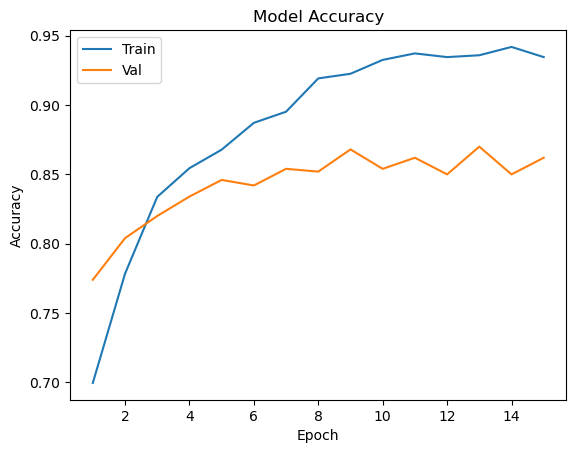

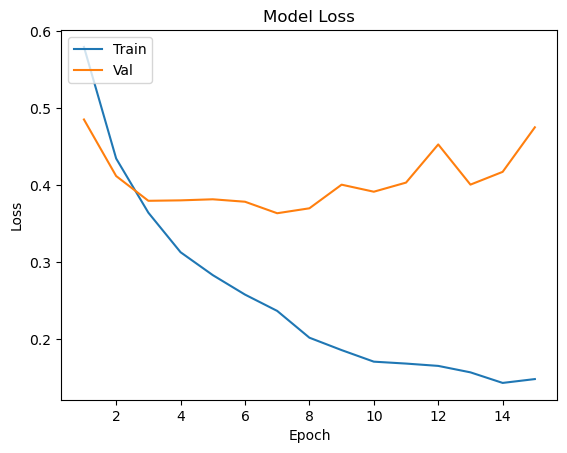

In [62]:
plot_learning_curve(history, NUMBER_OF_EPOCHS)

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

In [64]:
# predicted_cnn = cnn_model.predict_classes(X_raw_test)
predicted_cnn = np.argmax(cnn_model.predict(X_raw_test), axis=-1)

# Print metrics
print(confusion_matrix(y_raw_test, predicted_cnn))
print(accuracy_score(y_raw_test, predicted_cnn))
print(f1_score(y_raw_test, predicted_cnn, average='micro'))
# ConfusionMatrixDisplay.from_predictions(y_raw_test, predicted_cnn)

16/16 [==============================] - 0s 3ms/step
[[234  16]
 [ 53 197]]
0.862
0.8619999999999999


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_raw_test, predicted_cnn))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       250
           1       0.92      0.79      0.85       250

    accuracy                           0.86       500
   macro avg       0.87      0.86      0.86       500
weighted avg       0.87      0.86      0.86       500



In [66]:
# results = cnn_model.evaluate(X_raw_test, y_raw_test)
# print("test loss, test acc: ", results)

In [151]:
cnn_unfiltered_cv_metrics = feature_util_UPFall.cross_val_cnn(X_raw_train, y_raw_train, X_raw_train[0].shape, NUMBER_OF_EPOCHS, 5)
feature_util_UPFall.compute_cnn_cross_val_mean(cnn_unfiltered_cv_metrics)

0.8290947675704956


## II - Filtered

In [67]:
df_binary_combined_filtered = feature_util_UPFall.apply_filter(df_binary_combined_unfiltered.drop(['outcome'], axis=1), Fs)
df_binary_combined_filtered['outcome'] = df_binary_combined_unfiltered['outcome']
df_binary_combined_filtered

low cutoff 5 Hz


,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,outcome
0,-1.239993,-0.557012,0.227003,-75.855628,44.024217,315.910160,1
1,-1.395815,-0.573027,0.244548,-17.510872,63.490971,354.156199,1
2,-1.744661,-0.682261,0.253276,7.506246,90.429294,380.509092,1
3,-1.917599,-0.711281,0.212457,15.604800,93.930676,321.103727,1
4,-1.600448,-0.537416,0.154293,21.432435,60.552806,162.230385,1
...,...,...,...,...,...,...,...
294673,0.302927,0.548072,0.835784,0.751494,3.327992,-1.311439,0
294674,0.307568,0.548625,0.831561,1.894530,2.672211,-1.305462,0
294675,0.318312,0.555836,0.825309,2.196824,2.538146,-0.837104,0
294676,0.319360,0.559022,0.821402,0.958866,2.235342,-0.590168,0


In [68]:
X_filtered, y_filtered = feature_util_UPFall.get_frames_with_gyro(df_binary_combined_filtered, frame_size, hop_size, True)
features_filtered = feature_util_UPFall.extract_features_with_gyro(X_filtered)
features_filtered.shape

c:\Users\Alex\OneDrive - The University of Nottingham\Comp Sci\Year 3\Dissertation\Code\feature_util_UPFall.py:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['outcome'][i: i + frame_size])[0][0]


(6405, 22)

In [69]:
feature_filtered_df = pd.DataFrame(features_filtered)

y_filtered_df = pd.DataFrame(y_filtered)
y_filtered_df = y_filtered_df.rename(mapper={0:"outcome"}, axis=1)
y_filtered_df
feature_and_outcome_filtered_df = pd.concat([feature_filtered_df, y_filtered_df], axis=1)

In [70]:
feature_and_outcome_filtered_df['outcome'].value_counts()

0    5406
1     999
Name: outcome, dtype: int64

In [71]:
falls_filtered_df = feature_and_outcome_filtered_df[feature_and_outcome_filtered_df['outcome'] == 1]
not_falls_filtered_df = feature_and_outcome_filtered_df[feature_and_outcome_filtered_df['outcome'] == 0]

undersampled_not_falls_filtered = not_falls_filtered_df.sample(n=len(falls_filtered_df), random_state=42)
balanced_features_filtered = pd.concat([undersampled_not_falls_filtered, falls_filtered_df])
balanced_features_filtered = balanced_features_filtered.sample(frac=1, random_state=42)
balanced_features_filtered

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,outcome
3341,0.341367,0.341687,0.354032,0.515093,0.514474,0.507070,-1.503141,-1.503758,-1.466368,1.732506,...,0.368386,0.508040,0.517224,0.516856,-1.466369,-1.524798,-1.525282,1.738116,0.438457,0
6293,0.001175,-0.015456,-0.036232,0.560187,0.572161,0.595137,-1.112336,-1.039357,-0.966954,2.042366,...,0.019360,0.605057,0.573466,0.557313,-1.120865,-1.211275,-1.195503,1.639455,0.033858,0
4059,-0.368729,-0.345996,-0.373329,0.825933,0.805356,0.795684,2.406424,1.511112,2.814929,4.016918,...,-0.398463,0.846226,0.871069,0.839508,2.324767,2.004680,1.491748,4.512328,0.183490,0
161,-0.375385,-0.374542,-0.356853,0.491423,0.491454,0.484016,-1.508063,-1.524948,-1.470259,1.737571,...,-0.346937,0.485964,0.493435,0.492008,-1.461716,-1.484790,-1.478194,1.848466,0.292443,0
1580,0.391666,0.393049,0.419220,0.425922,0.426836,0.432482,-1.520940,-1.513195,-1.502550,1.683492,...,0.399500,0.432046,0.424441,0.421744,-1.501052,-1.487309,-1.493255,1.779119,0.071617,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,-0.053125,-0.046243,-0.006582,0.554495,0.551905,0.551676,-0.968651,-0.960233,-1.063879,1.763272,...,-0.048439,0.563834,0.572048,0.563274,-1.092340,-1.054889,-0.983018,1.836545,0.148420,1
1587,0.350666,0.388675,0.425035,0.529872,0.515836,0.562168,0.650296,-0.716891,2.979671,3.072991,...,0.327204,0.572950,0.625647,0.642220,2.755943,0.988817,1.483855,3.458907,0.020284,1
698,-0.295592,-0.295505,-0.288744,0.455133,0.454841,0.457971,-1.459284,-1.459384,-1.471702,1.602906,...,-0.313006,0.456415,0.460302,0.462056,-1.472044,-1.558620,-1.557949,1.606411,0.238345,0
2688,0.282414,0.244846,0.314236,0.604113,0.644256,0.561888,0.385703,1.031172,-0.207721,2.671703,...,0.368167,0.535970,0.534090,0.554445,-0.772236,-0.625432,-0.552083,2.367953,0.062314,1


In [72]:
features_filtered_shuffled = balanced_features_filtered.drop(columns=['outcome'])
features_filtered_shuffled

outcome_filtered_shuffled = balanced_features_filtered.loc[:,['outcome']]
outcome_filtered_shuffled.value_counts()

outcome
0          999
1          999
dtype: int64

In [73]:
X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(features_filtered_shuffled, outcome_filtered_shuffled, test_size=0.25, random_state=0, stratify=outcome_filtered_shuffled)

In [74]:
X_filtered_train.shape, X_filtered_test.shape, y_filtered_train.shape, y_filtered_test.shape

((1498, 22), (500, 22), (1498, 1), (500, 1))

In [75]:
unique, counts = np.unique(y_filtered_train, return_counts=True)
dict(zip(unique, counts))

{0: 749, 1: 749}

### Traditional Machine Learning Methods

In [76]:
filtered_model_name_array = []
filtered_model_acc_array = []

In [77]:
knn_model_filtered = KNeighborsClassifier(n_neighbors=5)
knn_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [78]:
# Predict on the test set
predicted_knn_filtered = knn_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_knn_filtered))
print(accuracy_score(y_filtered_test, predicted_knn_filtered))
print(f1_score(y_filtered_test, predicted_knn_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("knn")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_knn_filtered))

[[216  34]
 [ 64 186]]
0.804
0.804


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [79]:
# from sklearn.model_selection import GridSearchCV

# max_features_range = np.arange(1, 6, 1)
# n_estimators_range = np.arange(10, 210, 10)
# n_neighbors_range = np.arange(1, 100, 1)
# # param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, n_neighbors = n_neighbors_range)
# param_grid = dict(n_neighbors = n_neighbors_range)

# knnTest = KNeighborsClassifier(n_neighbors=5)

# grid = GridSearchCV(estimator=knnTest, param_grid=param_grid, scoring='accuracy', cv=5)

# grid.fit(X_train, y_train)
# print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

In [80]:
svm_model_filtered = svm.SVC(kernel='linear', C=1, random_state=0)
# gaussian
svm_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', random_state=0)

In [81]:
# Predict on the test set
predicted_svm_filtered = svm_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_svm_filtered))
print(accuracy_score(y_filtered_test, predicted_svm_filtered))
print(f1_score(y_filtered_test, predicted_svm_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("svm")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_svm_filtered))

[[201  49]
 [103 147]]
0.696
0.696


In [82]:
svm_rbf_model_filtered = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_rbf_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=0)

In [83]:
# Predict on the test set
predicted_svm_rbf_filtered = svm_rbf_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_svm_rbf_filtered))
print(accuracy_score(y_filtered_test, predicted_svm_rbf_filtered))
print(f1_score(y_filtered_test, predicted_svm_rbf_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("svm_rbf")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_svm_rbf_filtered))

[[223  27]
 [100 150]]
0.746
0.746


In [84]:
rf_model_filtered = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model_filtered.fit(X_filtered_train, y_filtered_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_35204\3673001609.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_filtered.fit(X_filtered_train, y_filtered_train)


RandomForestClassifier(random_state=42)

In [85]:
# Predict on the test set
predicted_rf_filtered = rf_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_rf_filtered))
print(accuracy_score(y_filtered_test, predicted_rf_filtered))
print(f1_score(y_filtered_test, predicted_rf_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("rf")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_rf_filtered))

[[215  35]
 [ 37 213]]
0.856
0.856


In [86]:
nb_model_filtered = GaussianNB()
nb_model_filtered.fit(X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [87]:
# Predict on the test set
predicted_nb_filtered = nb_model_filtered.predict(X_filtered_test)

# Print metrics
print(confusion_matrix(y_filtered_test, predicted_nb_filtered))
print(accuracy_score(y_filtered_test, predicted_nb_filtered))
print(f1_score(y_filtered_test, predicted_nb_filtered, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_model_name_array.append("nb")
filtered_model_acc_array.append(accuracy_score(y_filtered_test, predicted_nb_filtered))

[[222  28]
 [150 100]]
0.644
0.644


In [88]:
best_trad_model_acc_filtered = max(filtered_model_acc_array)
index = filtered_model_acc_array.index(max(filtered_model_acc_array))
best_trad_model_filtered = filtered_model_name_array[index]
print(f"Best model: {best_trad_model_filtered}, Accuracy: {best_trad_model_acc_filtered}")

Best model: rf, Accuracy: 0.856


In [89]:
for i in range(0, len(filtered_model_name_array)):
    print(f"name: {filtered_model_name_array[i]}, accuracy: {filtered_model_acc_array[i]}")

name: knn, accuracy: 0.804
name: svm, accuracy: 0.696
name: svm_rbf, accuracy: 0.746
name: rf, accuracy: 0.856
name: nb, accuracy: 0.644


In [90]:
filtered_model_dictionary = {"knn": knn_model_filtered,
                             "svm": svm_model_filtered,
                             "svm_rbf": svm_rbf_model_filtered,
                             "rf": rf_model_filtered,
                             "nb": nb_model_filtered}

In [91]:
scores_array_filtered = perform_cross_val_all_models(filtered_model_dictionary, X_filtered_train, y_filtered_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [92]:
for cv_tuple in scores_array_filtered:
    print("%s Accuracy: %0.2f (+/- %0.2f)" % (cv_tuple[0], cv_tuple[1].mean(), cv_tuple[1].std() * 2))

knn Accuracy: 0.81 (+/- 0.05)
svm Accuracy: 0.68 (+/- 0.07)
svm_rbf Accuracy: 0.76 (+/- 0.03)
rf Accuracy: 0.83 (+/- 0.03)
nb Accuracy: 0.66 (+/- 0.01)


In [93]:
print_all_classification_reports(filtered_model_dictionary, X_filtered_test, y_filtered_test)

Classification report for knn
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       250
           1       0.85      0.74      0.79       250

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500

Classification report for svm
              precision    recall  f1-score   support

           0       0.66      0.80      0.73       250
           1       0.75      0.59      0.66       250

    accuracy                           0.70       500
   macro avg       0.71      0.70      0.69       500
weighted avg       0.71      0.70      0.69       500

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       250
           1       0.85      0.60      0.70       250

    accuracy                           0.75       500
   macro avg       0.77      0.75 

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [94]:
print_all_classification_reports_training(filtered_model_dictionary, X_filtered_train, y_filtered_train)

Classification report for knn
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       749
           1       0.90      0.84      0.87       749

    accuracy                           0.88      1498
   macro avg       0.88      0.88      0.88      1498
weighted avg       0.88      0.88      0.88      1498

Classification report for svm
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       749
           1       0.75      0.60      0.67       749

    accuracy                           0.70      1498
   macro avg       0.71      0.70      0.70      1498
weighted avg       0.71      0.70      0.70      1498

Classification report for svm_rbf


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.71      0.90      0.79       749
           1       0.86      0.63      0.73       749

    accuracy                           0.76      1498
   macro avg       0.78      0.76      0.76      1498
weighted avg       0.78      0.76      0.76      1498

Classification report for rf
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       749

    accuracy                           1.00      1498
   macro avg       1.00      1.00      1.00      1498
weighted avg       1.00      1.00      1.00      1498

Classification report for nb
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       749
           1       0.79      0.44      0.57       749

    accuracy                           0.66      1498
   macro avg       0.70      0.66      0.65      1498
weighted avg    

In [95]:
from joblib import dump, load
# save clf using joblib
# dump(rf_model, 'New Models/rf_filtered_normalised.joblib')

### Deep Learning

#### The models below are trained using data which went through low-pass filter

In [96]:
X_filtered_undersampled, y_filtered_undersampled = feature_util_UPFall.balance_windows_undersample(X_filtered, y_filtered)
X_filtered_undersampled.shape, y_filtered_undersampled.shape

((1998, 92, 6), (1998,))

In [97]:
# X_raw_filtered_train, X_raw_filtered_test, y_raw_filtered_train, y_raw_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.25, random_state=0, stratify=y_filtered)
X_raw_filtered_train, X_raw_filtered_test, y_raw_filtered_train, y_raw_filtered_test = train_test_split(X_filtered_undersampled, y_filtered_undersampled, test_size=0.25, random_state=0, stratify=y_filtered_undersampled)
X_raw_filtered_train.shape, X_raw_filtered_test.shape, y_raw_filtered_train.shape

((1498, 92, 6), (500, 92, 6), (1498,))

In [98]:
X_raw_filtered_train[0].shape

(92, 6)

In [99]:
X_raw_filtered_train = X_raw_filtered_train.reshape(X_TRAIN_SIZE, X_TRAIN_WINDOW_SIZE, 6, 1)
X_raw_filtered_test = X_raw_filtered_test.reshape(X_TEST_SIZE, X_TEST_WINDOW_SIZE, 6, 1)

In [100]:
X_raw_filtered_train[0].shape, X_raw_filtered_test[0].shape

((92, 6, 1), (92, 6, 1))

In [101]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [102]:
cnn_model_filtered = Sequential()
cnn_model_filtered.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_filtered_train[0].shape))
cnn_model_filtered.add(Conv2D(32, (2, 2), activation='relu'))
cnn_model_filtered.add(Flatten())
cnn_model_filtered.add(Dense(64, activation='relu'))
cnn_model_filtered.add(Dense(2, activation='softmax'))

In [103]:
cnn_model_filtered.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [104]:
history_filtered = cnn_model_filtered.fit(X_raw_filtered_train, y_raw_filtered_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_raw_filtered_test, y_raw_filtered_test), verbose=1)

Epoch 1/15
47/47 [==============================] - 2s 19ms/step - loss: 0.5654 - accuracy: 0.7096 - val_loss: 0.4619 - val_accuracy: 0.7680
Epoch 2/15
47/47 [==============================] - 1s 15ms/step - loss: 0.4250 - accuracy: 0.7957 - val_loss: 0.4202 - val_accuracy: 0.8020
Epoch 3/15
47/47 [==============================] - 1s 15ms/step - loss: 0.3656 - accuracy: 0.8111 - val_loss: 0.3887 - val_accuracy: 0.8320
Epoch 4/15
47/47 [==============================] - 1s 15ms/step - loss: 0.3175 - accuracy: 0.8598 - val_loss: 0.4247 - val_accuracy: 0.8260
Epoch 5/15
47/47 [==============================] - 1s 18ms/step - loss: 0.2840 - accuracy: 0.8718 - val_loss: 0.3747 - val_accuracy: 0.8300
Epoch 6/15
47/47 [==============================] - 1s 17ms/step - loss: 0.2568 - accuracy: 0.8725 - val_loss: 0.3644 - val_accuracy: 0.8560
Epoch 7/15
47/47 [==============================] - 1s 15ms/step - loss: 0.2282 - accuracy: 0.8979 - val_loss: 0.3686 - val_accuracy: 0.8420
Epoch 8/15
47

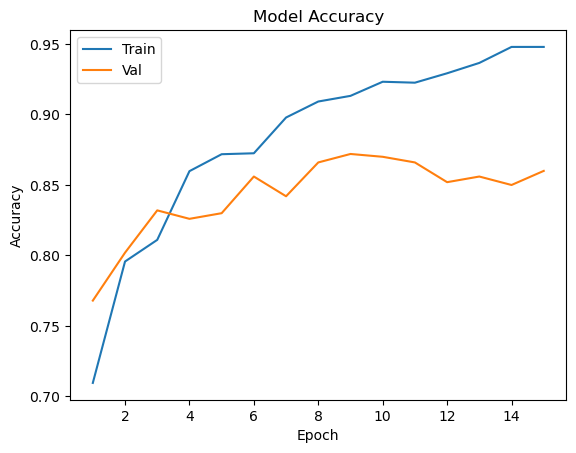

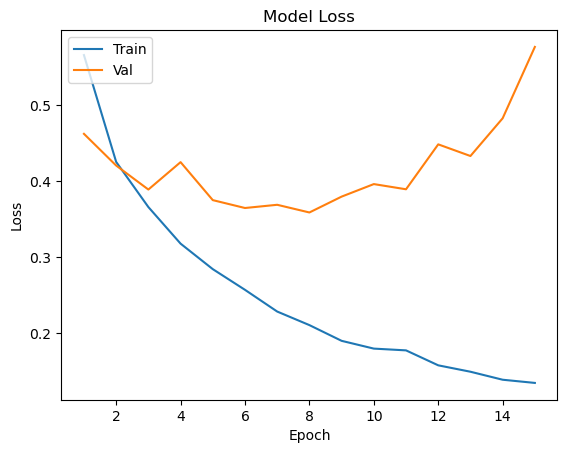

In [105]:
plot_learning_curve(history_filtered, NUMBER_OF_EPOCHS)

In [106]:
# predicted_cnn = cnn_model.predict_classes(X_raw_test)
predicted_cnn_filtered = np.argmax(cnn_model_filtered.predict(X_raw_filtered_test), axis=-1)

# Print metrics
print(confusion_matrix(y_raw_filtered_test, predicted_cnn_filtered))
print(accuracy_score(y_raw_filtered_test, predicted_cnn_filtered))
print(f1_score(y_raw_filtered_test, predicted_cnn_filtered, average='micro'))
# ConfusionMatrixDisplay.from_predictions(y_raw_test, predicted_cnn)

16/16 [==============================] - 0s 3ms/step
[[209  41]
 [ 29 221]]
0.86
0.8599999999999999


In [107]:
from sklearn.metrics import classification_report

print(classification_report(y_raw_filtered_test, predicted_cnn_filtered))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       250
           1       0.84      0.88      0.86       250

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [108]:
results_filtered = cnn_model_filtered.evaluate(X_raw_filtered_test, y_raw_filtered_test)
print("test loss, test acc: ", results_filtered)

16/16 [==============================] - 0s 3ms/step - loss: 0.5762 - accuracy: 0.8600
test loss, test acc:  [0.5761905312538147, 0.8600000143051147]


In [152]:
cnn_filtered_cv_metrics = feature_util_UPFall.cross_val_cnn(X_raw_filtered_train, y_raw_filtered_train, X_raw_filtered_train[0].shape, NUMBER_OF_EPOCHS, 5)
feature_util_UPFall.compute_cnn_cross_val_mean(cnn_filtered_cv_metrics)

0.8357569694519043


In [155]:
# cnn_model_filtered.save('Final Models/exp3_cnn_filtered')

INFO:tensorflow:Assets written to: Final Models/exp3_cnn_filtered\assets


INFO:tensorflow:Assets written to: Final Models/exp3_cnn_filtered\assets


## III - Filtered and Normalised

In [109]:
df_binary_combined_filtered_normalised = feature_util_UPFall.normalise_df(df_binary_combined_filtered.drop(['outcome'], axis=1))
df_binary_combined_filtered_normalised['outcome'] = df_binary_combined_filtered['outcome']
df_binary_combined_filtered_normalised

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,outcome
0,0.342280,0.395239,0.569756,0.414420,0.503240,0.582203,1
1,0.328154,0.393832,0.571100,0.436878,0.513690,0.604337,1
2,0.296528,0.384230,0.571769,0.446508,0.528152,0.619588,1
3,0.280850,0.381679,0.568642,0.449625,0.530032,0.585209,1
4,0.309602,0.396962,0.564188,0.451869,0.512113,0.493265,1
...,...,...,...,...,...,...,...
294673,0.482159,0.492373,0.616383,0.443908,0.481392,0.398619,0
294674,0.482580,0.492422,0.616059,0.444348,0.481040,0.398623,0
294675,0.483554,0.493055,0.615580,0.444464,0.480968,0.398894,0
294676,0.483649,0.493335,0.615281,0.443988,0.480805,0.399036,0


In [110]:
X_filtered_normalised, y_filtered_normalised = feature_util_UPFall.get_frames_with_gyro(df_binary_combined_filtered_normalised, frame_size, hop_size, True)
features_filtered_normalised = feature_util_UPFall.extract_features_with_gyro(X_filtered_normalised)
features_filtered_normalised.shape

c:\Users\Alex\OneDrive - The University of Nottingham\Comp Sci\Year 3\Dissertation\Code\feature_util_UPFall.py:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['outcome'][i: i + frame_size])[0][0]


(6405, 22)

In [111]:
feature_filtered_normalised_df = pd.DataFrame(features_filtered_normalised)

y_filtered_normalised_df = pd.DataFrame(y_filtered)
y_filtered_normalised_df = y_filtered_normalised_df.rename(mapper={0:"outcome"}, axis=1)
y_filtered_normalised_df
feature_and_outcome_filtered_normalised_df = pd.concat([feature_filtered_normalised_df, y_filtered_normalised_df], axis=1)

In [112]:
feature_and_outcome_filtered_normalised_df['outcome'].value_counts()

0    5406
1     999
Name: outcome, dtype: int64

In [113]:
falls_filtered_normalised_df = feature_and_outcome_filtered_normalised_df[feature_and_outcome_filtered_normalised_df['outcome'] == 1]
not_falls_filtered_normalised_df = feature_and_outcome_filtered_normalised_df[feature_and_outcome_filtered_normalised_df['outcome'] == 0]

undersampled_not_falls_filtered_normalised = not_falls_filtered_normalised_df.sample(n=len(falls_filtered_normalised_df), random_state=42)
balanced_features_filtered_normalised = pd.concat([undersampled_not_falls_filtered_normalised, falls_filtered_normalised_df])
balanced_features_filtered_normalised = balanced_features_filtered_normalised.sample(frac=1, random_state=42)
balanced_features_filtered_normalised

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,outcome
3341,0.509195,0.509229,0.510101,0.084972,0.084892,0.084294,-1.458448,-1.458571,-1.455409,1.089425,...,0.513458,0.084376,0.086006,0.085998,-1.455414,-1.577947,-1.578112,1.089854,0.746878,0
6293,0.483223,0.481863,0.479714,0.075067,0.075692,0.078966,-1.690253,-1.650120,-1.650318,0.989015,...,0.486959,0.080470,0.077715,0.074909,-1.675270,-1.662334,-1.635824,1.007304,0.633375,0
4059,0.449525,0.451768,0.449136,0.101657,0.098383,0.097911,0.211955,-0.124777,0.347678,1.021423,...,0.448761,0.103235,0.108022,0.105559,0.175011,-0.063799,-0.303852,1.023497,0.381499,0
161,0.448403,0.448481,0.449850,0.086213,0.086140,0.085463,-1.457112,-1.461441,-1.457837,0.994168,...,0.453008,0.085658,0.087335,0.087255,-1.456146,-1.568423,-1.566712,0.999803,0.620021,0
1580,0.516060,0.516164,0.518232,0.056240,0.056422,0.055640,-1.520927,-1.523385,-1.456676,1.014291,...,0.518791,0.055762,0.056104,0.056140,-1.459705,-1.474936,-1.476004,1.014105,0.767538,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,0.479831,0.480372,0.483640,0.047713,0.048126,0.046003,0.043543,-0.004394,0.088956,0.973266,...,0.482393,0.047595,0.048285,0.048586,0.031921,0.491241,0.315381,0.973939,0.621060,1
1587,0.513058,0.516190,0.518941,0.057816,0.058313,0.062363,-0.834600,-0.205328,2.334407,1.155728,...,0.513005,0.063133,0.065813,0.066530,2.148200,0.525096,-0.002534,1.212570,0.666167,1
698,0.460371,0.460377,0.460746,0.017242,0.017263,0.017075,-1.508163,-1.504441,-1.456974,0.836943,...,0.461195,0.017125,0.017394,0.017323,-1.459734,-1.515478,-1.515559,0.837878,0.759569,0
2688,0.506575,0.503394,0.509226,0.075304,0.078267,0.072361,-0.685889,-0.323129,-0.787883,1.074140,...,0.515959,0.071246,0.071228,0.071867,-1.003463,-1.116688,-1.147560,1.072564,0.692598,1


In [114]:
features_filtered_normalised_shuffled = balanced_features_filtered_normalised.drop(columns=['outcome'])
features_filtered_normalised_shuffled

outcome_filtered_normalised_shuffled = balanced_features_filtered_normalised.loc[:,['outcome']]
outcome_filtered_normalised_shuffled.value_counts()

outcome
0          999
1          999
dtype: int64

In [115]:
X_filtered_normalised_train, X_filtered_normalised_test, y_filtered_normalised_train, y_filtered_normalised_test = train_test_split(features_filtered_normalised_shuffled, outcome_filtered_normalised_shuffled, test_size=0.25, random_state=0, stratify=outcome_filtered_normalised_shuffled)

In [116]:
X_filtered_normalised_train.shape, X_filtered_normalised_test.shape, y_filtered_normalised_train.shape, y_filtered_normalised_test.shape

((1498, 22), (500, 22), (1498, 1), (500, 1))

In [117]:
unique, counts = np.unique(y_filtered_train, return_counts=True)
dict(zip(unique, counts))

{0: 749, 1: 749}

### Traditional Machine Learning Methods

In [118]:
filtered_normalised_model_name_array = []
filtered_normalised_model_acc_array = []

In [119]:
knn_model_filtered_normalised = KNeighborsClassifier(n_neighbors=5)
knn_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [120]:
# Predict on the test set
predicted_knn_filtered_normalised = knn_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_knn_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_knn_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_knn_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("knn")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_knn_filtered_normalised))

[[205  45]
 [ 60 190]]
0.79
0.79


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [121]:
# from sklearn.model_selection import GridSearchCV

# max_features_range = np.arange(1, 6, 1)
# n_estimators_range = np.arange(10, 210, 10)
# n_neighbors_range = np.arange(1, 100, 1)
# # param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range, n_neighbors = n_neighbors_range)
# param_grid = dict(n_neighbors = n_neighbors_range)

# knnTest = KNeighborsClassifier(n_neighbors=5)

# grid = GridSearchCV(estimator=knnTest, param_grid=param_grid, scoring='accuracy', cv=5)

# grid.fit(X_train, y_train)
# print("The best parameters are %s with a score of %f" % (grid.best_params_, grid.best_score_))

In [122]:
svm_model_filtered_normalised = svm.SVC(kernel='linear', C=1, random_state=0)
# gaussian
svm_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', random_state=0)

In [123]:
# Predict on the test set
predicted_svm_filtered_normalised = svm_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_svm_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_svm_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_svm_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("svm")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_svm_filtered_normalised))

[[183  67]
 [ 82 168]]
0.702
0.702


In [124]:
svm_rbf_model_filtered_normalised = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_rbf_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, random_state=0)

In [125]:
# Predict on the test set
predicted_svm_rbf_filtered_normalised = svm_rbf_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("svm_rbf")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_svm_rbf_filtered_normalised))

[[215  35]
 [119 131]]
0.692
0.692


In [126]:
rf_model_filtered_normalised = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model_filtered_normalised.fit(X_filtered_train, y_filtered_normalised_train)

C:\Users\Alex\AppData\Local\Temp\ipykernel_35204\1829240526.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_filtered_normalised.fit(X_filtered_train, y_filtered_normalised_train)


RandomForestClassifier(random_state=42)

In [127]:
# Predict on the test set
predicted_rf_filtered_normalised = rf_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_rf_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_rf_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_rf_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("rf")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_rf_filtered_normalised))

[[ 13 237]
 [ 37 213]]
0.452
0.452


In [128]:
nb_model_filtered_normalised = GaussianNB()
nb_model_filtered_normalised.fit(X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [129]:
# Predict on the test set
predicted_nb_filtered_normalised = nb_model_filtered_normalised.predict(X_filtered_normalised_test)

# Print metrics
print(confusion_matrix(y_filtered_normalised_test, predicted_nb_filtered_normalised))
print(accuracy_score(y_filtered_normalised_test, predicted_nb_filtered_normalised))
print(f1_score(y_filtered_normalised_test, predicted_nb_filtered_normalised, average='micro'))
# compare_trad_models("knn", accuracy_score(y_test, predicted))
filtered_normalised_model_name_array.append("nb")
filtered_normalised_model_acc_array.append(accuracy_score(y_filtered_normalised_test, predicted_nb_filtered_normalised))

[[222  28]
 [171  79]]
0.602
0.602


In [130]:
best_trad_model_acc_filtered_normalised = max(filtered_normalised_model_acc_array)
index = filtered_normalised_model_acc_array.index(max(filtered_normalised_model_acc_array))
best_trad_model_filtered_normalised = filtered_normalised_model_name_array[index]
print(f"Best model: {best_trad_model_filtered_normalised}, Accuracy: {best_trad_model_acc_filtered_normalised}")

Best model: knn, Accuracy: 0.79


In [131]:
for i in range(0, len(filtered_normalised_model_name_array)):
    print(f"name: {filtered_normalised_model_name_array[i]}, accuracy: {filtered_normalised_model_acc_array[i]}")

name: knn, accuracy: 0.79
name: svm, accuracy: 0.702
name: svm_rbf, accuracy: 0.692
name: rf, accuracy: 0.452
name: nb, accuracy: 0.602


In [132]:
filtered_normalised_model_dictionary = {"knn": knn_model_filtered_normalised,
                             "svm": svm_model_filtered_normalised,
                             "svm_rbf": svm_rbf_model_filtered_normalised,
                             "rf": rf_model_filtered_normalised,
                             "nb": nb_model_filtered_normalised}

In [133]:
scores_array_filtered_normalised = perform_cross_val_all_models(filtered_normalised_model_dictionary, X_filtered_normalised_train, y_filtered_normalised_train)

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [134]:
for cv_tuple in scores_array_filtered_normalised:
    print("%s Accuracy: %0.2f (+/- %0.2f)" % (cv_tuple[0], cv_tuple[1].mean(), cv_tuple[1].std() * 2))

knn Accuracy: 0.78 (+/- 0.03)
svm Accuracy: 0.70 (+/- 0.04)
svm_rbf Accuracy: 0.72 (+/- 0.04)
rf Accuracy: 0.85 (+/- 0.05)
nb Accuracy: 0.60 (+/- 0.07)


In [135]:
print_all_classification_reports(filtered_normalised_model_dictionary, X_filtered_normalised_test, y_filtered_normalised_test)

Classification report for knn
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       250
           1       0.81      0.76      0.78       250

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

Classification report for svm
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       250
           1       0.71      0.67      0.69       250

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.64      0.86      0.74       250
           1       0.79      0.52      0.63       250

    accuracy                           0.69       500
   macro avg       0.72      0.69 

c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.26      0.05      0.09       250
           1       0.47      0.85      0.61       250

    accuracy                           0.45       500
   macro avg       0.37      0.45      0.35       500
weighted avg       0.37      0.45      0.35       500

Classification report for nb
              precision    recall  f1-score   support

           0       0.56      0.89      0.69       250
           1       0.74      0.32      0.44       250

    accuracy                           0.60       500
   macro avg       0.65      0.60      0.57       500
weighted avg       0.65      0.60      0.57       500



In [136]:
print_all_classification_reports_training(filtered_normalised_model_dictionary, X_filtered_normalised_train, y_filtered_normalised_train)

Classification report for knn


c:\Users\Alex\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       749
           1       0.85      0.85      0.85       749

    accuracy                           0.85      1498
   macro avg       0.85      0.85      0.85      1498
weighted avg       0.85      0.85      0.85      1498

Classification report for svm
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       749
           1       0.71      0.68      0.69       749

    accuracy                           0.70      1498
   macro avg       0.70      0.70      0.70      1498
weighted avg       0.70      0.70      0.70      1498

Classification report for svm_rbf
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       749
           1       0.81      0.59      0.68       749

    accuracy                           0.72      1498
   macro avg       0.74      0.72      0.72      1498
weighted a

In [137]:
from joblib import dump, load
# save clf using joblib
# dump(rf_model, 'New Models/rf_filtered_normalised.joblib')

### Deep Learning

#### The models below are trained using data which went through low-pass filter

In [138]:
X_filtered_normalised_undersampled, y_filtered_normalised_undersampled = feature_util_UPFall.balance_windows_undersample(X_filtered_normalised, y_filtered_normalised)
X_filtered_normalised_undersampled.shape, y_filtered_normalised_undersampled.shape

((1998, 92, 6), (1998,))

In [139]:
X_raw_filtered_normalised_train, X_raw_filtered_normalised_test, y_raw_filtered_normalised_train, y_raw_filtered_normalised_test = train_test_split(X_filtered_normalised_undersampled, y_filtered_normalised_undersampled, test_size=0.25, random_state=0, stratify=y_filtered_normalised_undersampled)
X_raw_filtered_normalised_train.shape, X_raw_filtered_normalised_test.shape, y_raw_filtered_normalised_train.shape

((1498, 92, 6), (500, 92, 6), (1498,))

In [140]:
X_raw_filtered_normalised_train[0].shape

(92, 6)

In [141]:
X_raw_filtered_normalised_train = X_raw_filtered_normalised_train.reshape(X_TRAIN_SIZE, X_TRAIN_WINDOW_SIZE, 6, 1)
X_raw_filtered_normalised_test = X_raw_filtered_normalised_test.reshape(X_TEST_SIZE, X_TEST_WINDOW_SIZE, 6, 1)

In [142]:
X_raw_filtered_normalised_train[0].shape, X_raw_filtered_normalised_test[0].shape

((92, 6, 1), (92, 6, 1))

In [143]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [144]:
cnn_model_filtered_normalised = Sequential()
cnn_model_filtered_normalised.add(Conv2D(16, (2, 2), activation='relu', input_shape=X_raw_filtered_normalised_train[0].shape))
cnn_model_filtered_normalised.add(Conv2D(32, (2, 2), activation='relu'))
cnn_model_filtered_normalised.add(Flatten())
cnn_model_filtered_normalised.add(Dense(64, activation='relu'))
cnn_model_filtered_normalised.add(Dense(2, activation='softmax'))

In [145]:
cnn_model_filtered_normalised.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [146]:
history_filtered_normalised = cnn_model_filtered_normalised.fit(X_raw_filtered_normalised_train, y_raw_filtered_normalised_train, epochs=NUMBER_OF_EPOCHS, validation_data=(X_raw_filtered_normalised_test, y_raw_filtered_normalised_test), verbose=1)

Epoch 1/15
47/47 [==============================] - 4s 31ms/step - loss: 0.7038 - accuracy: 0.4820 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/15
47/47 [==============================] - 1s 27ms/step - loss: 0.6933 - accuracy: 0.4940 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/15
47/47 [==============================] - 1s 27ms/step - loss: 0.6936 - accuracy: 0.5080 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/15
47/47 [==============================] - 1s 27ms/step - loss: 0.6926 - accuracy: 0.5367 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 5/15
47/47 [==============================] - 1s 27ms/step - loss: 0.6916 - accuracy: 0.5220 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 6/15
47/47 [==============================] - 1s 22ms/step - loss: 0.6916 - accuracy: 0.5381 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 7/15
47/47 [==============================] - 1s 28ms/step - loss: 0.6904 - accuracy: 0.5661 - val_loss: 0.6888 - val_accuracy: 0.5680
Epoch 8/15
47

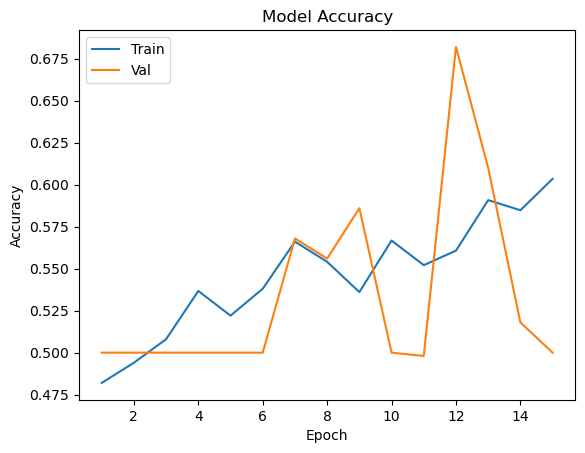

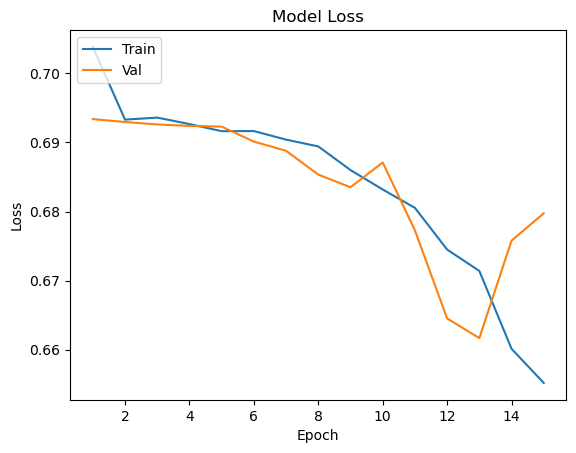

In [147]:
plot_learning_curve(history_filtered_normalised, NUMBER_OF_EPOCHS)

In [148]:
# predicted_cnn = cnn_model.predict_classes(X_raw_test)
predicted_cnn_filtered_normalised = np.argmax(cnn_model_filtered_normalised.predict(X_raw_filtered_normalised_test), axis=-1)

# Print metrics
print(confusion_matrix(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised))
print(accuracy_score(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised))
print(f1_score(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised, average='micro'))
# ConfusionMatrixDisplay.from_predictions(y_raw_test, predicted_cnn)

16/16 [==============================] - 0s 8ms/step
[[202  48]
 [202  48]]
0.5
0.5


In [149]:
from sklearn.metrics import classification_report

print(classification_report(y_raw_filtered_normalised_test, predicted_cnn_filtered_normalised))

              precision    recall  f1-score   support

           0       0.50      0.81      0.62       250
           1       0.50      0.19      0.28       250

    accuracy                           0.50       500
   macro avg       0.50      0.50      0.45       500
weighted avg       0.50      0.50      0.45       500



In [150]:
results_filtered_normalised = cnn_model_filtered.evaluate(X_raw_filtered_normalised_test, y_raw_filtered_normalised_test)
print("test loss, test acc: ", results_filtered_normalised)

16/16 [==============================] - 0s 8ms/step - loss: 0.7663 - accuracy: 0.4940
test loss, test acc:  [0.7663061618804932, 0.49399998784065247]


In [153]:
cnn_filtered_normalised_cv_metrics = feature_util_UPFall.cross_val_cnn(X_raw_filtered_normalised_train, y_raw_filtered_normalised_train, X_raw_filtered_normalised_train[0].shape, NUMBER_OF_EPOCHS, 5)
feature_util_UPFall.compute_cnn_cross_val_mean(cnn_filtered_normalised_cv_metrics)

0.661612045764923
